In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from scipy import stats
from scipy.stats import norm, skew
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import xgboost as xgb
from pandas.tseries.holiday import *


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [26]:
from sklearn.model_selection import KFold
from sklearn.cluster import MiniBatchKMeans


In [2]:
# Read the train and test datasets
df_train = pd.read_csv('train.csv', nrows = 20000000)
df_test = pd.read_csv('test.csv')

## Data Preprocessing and Cleaning

In [3]:
df_train.head()

key  fare_amount          pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5  2009-06-15 17:26:21 UTC   
1    2010-01-05 16:52:16.0000002         16.9  2010-01-05 16:52:16 UTC   
2   2011-08-18 00:35:00.00000049          5.7  2011-08-18 00:35:00 UTC   
3    2012-04-21 04:30:42.0000001          7.7  2012-04-21 04:30:42 UTC   
4  2010-03-09 07:51:00.000000135          5.3  2010-03-09 07:51:00 UTC   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  
0                1  
1                1  
2                2  
3                1  
4                1

In [4]:
df_train.describe()

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  2.000000e+07      2.000000e+07     2.000000e+07       1.999986e+07   
mean   1.134298e+01     -7.251140e+01     3.992070e+01      -7.251060e+01   
std    1.689916e+01      1.298955e+01     9.388927e+00       1.290617e+01   
min   -1.077500e+02     -3.439245e+03    -3.492264e+03      -3.442025e+03   
25%    6.000000e+00     -7.399207e+01     4.073491e+01      -7.399140e+01   
50%    8.500000e+00     -7.398181e+01     4.075263e+01      -7.398016e+01   
75%    1.250000e+01     -7.396709e+01     4.076712e+01      -7.396368e+01   
max    6.155086e+04      3.457626e+03     3.406008e+03       3.457622e+03   

       dropoff_latitude  passenger_count  
count      1.999986e+07     2.000000e+07  
mean       3.991950e+01     1.685312e+00  
std        9.570037e+00     1.321177e+00  
min       -3.493652e+03     0.000000e+00  
25%        4.073403e+01     1.000000e+00  
50%        4.075315e+01     1.000000e+00  
75%        4.076809e+01     2.000000e+00  
max        3.400392e+03     2.080000e+02

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000000 entries, 0 to 19999999
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   key                object 
 1   fare_amount        float64
 2   pickup_datetime    object 
 3   pickup_longitude   float64
 4   pickup_latitude    float64
 5   dropoff_longitude  float64
 6   dropoff_latitude   float64
 7   passenger_count    int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 1.2+ GB


### Outlier Removal

In [8]:
#Remove outliers
df_train.drop(df_train[df_train['fare_amount'] < 2.5].index, axis=0, inplace = True)
df_train.drop(df_train[df_train['fare_amount'] > 500].index, axis=0, inplace = True)
df_train.drop(df_train[df_train['pickup_longitude'] == 0].index, axis=0, inplace = True)
df_train.drop(df_train[df_train['pickup_latitude'] == 0].index, axis=0, inplace = True)
df_train.drop(df_train[df_train['dropoff_longitude'] == 0].index, axis=0, inplace = True)
df_train.drop(df_train[df_train['dropoff_latitude'] == 0].index, axis=0, inplace = True)
df_train.drop(df_train[df_train['passenger_count'] == 208].index, axis=0, inplace = True)
df_train.drop(df_train[df_train['passenger_count'] > 5].index, axis=0, inplace = True)
df_train.drop(df_train[df_train['passenger_count'] == 0].index, axis=0, inplace = True)

In [9]:
# Remove outliers
avg = np.mean(df_train['fare_amount'])
print("Mean for Fare Amount is:", avg)

sd = np.std(df_train['fare_amount'])
print("Standard Deviation for Fare Amount is:", sd)

df_train = df_train[df_train['fare_amount'].between(avg - 2*sd, avg + 2*sd, inclusive = True)]
df_train.describe()

Mean for Fare Amount is: 11.315130209503602
Standard Deviation for Fare Amount is: 9.69535903084128


C:\Users\Rohan Kapur\AppData\Local\Temp\ipykernel_23684\2311384368.py:8: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  df_train = df_train[df_train['fare_amount'].between(avg - 2*sd, avg + 2*sd, inclusive = True)]


fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  1.819428e+07      1.819428e+07     1.819428e+07       1.819428e+07   
mean   9.603032e+00     -7.392627e+01     4.069890e+01      -7.392154e+01   
std    5.274567e+00      8.181829e+00     7.453587e+00       8.196893e+00   
min    2.500000e+00     -3.439245e+03    -3.492264e+03      -3.442025e+03   
25%    6.000000e+00     -7.399252e+01     4.073712e+01      -7.399172e+01   
50%    8.100000e+00     -7.398234e+01     4.075342e+01      -7.398094e+01   
75%    1.170000e+01     -7.396959e+01     4.076729e+01      -7.396667e+01   
max    3.070000e+01      3.457626e+03     3.406008e+03       3.457622e+03   

       dropoff_latitude  passenger_count  
count      1.819428e+07     1.819428e+07  
mean       4.069598e+01     1.595979e+00  
std        7.779587e+00     1.154577e+00  
min       -3.493652e+03     1.000000e+00  
25%        4.073657e+01     1.000000e+00  
50%        4.075400e+01     1.000000e+00  
75%        4.076835e+01     2.000000e+00  
max        3.390614e+03     5.000000e+00

In [38]:
df_train.dropna(inplace=True)

df_train.drop(df_train.index[(df_train.pickup_longitude < -75) | 
           (df_train.pickup_longitude > -72) | 
           (df_train.pickup_latitude < 40) | 
           (df_train.pickup_latitude > 42)],inplace=True)
df_train.drop(df_train.index[(df_train.dropoff_longitude < -75) | 
           (df_train.dropoff_longitude > -72) | 
           (df_train.dropoff_latitude < 40) | 
           (df_train.dropoff_latitude > 42)],inplace=True)

### Feature Extraction

In [10]:
# Feature Extraction
# Decomposing timestamp for train data into date and time

key = df_test.key
df_train['pickup_datetime']  = pd.to_datetime(df_train['pickup_datetime'], format = '%Y-%m-%d %H:%M:%S UTC')
df_test['pickup_datetime']  = pd.to_datetime(df_train['pickup_datetime'], format = '%Y-%m-%d %H:%M:%S UTC')

In [11]:
df_train.loc[:, 'date'] = df_train['pickup_datetime'].dt.date
df_train.loc[:, 'time'] = df_train['pickup_datetime'].dt.time
df_train.loc[:, 'weekday'] = df_train['pickup_datetime'].dt.weekday
df_train.loc[:, 'weekofyear'] = df_train['pickup_datetime'].dt.weekofyear
df_train.loc[:, 'hour'] = df_train['pickup_datetime'].dt.hour
df_train.loc[:, 'minute'] = df_train['pickup_datetime'].dt.minute
df_train.loc[:, 'dt'] = (df_train['pickup_datetime'] - df_train['pickup_datetime'].min()).dt.total_seconds()
df_train.loc[:, 'week_hour'] = df_train['weekday'] * 24 + df_train['hour']
df_train.loc[:, 'dayofyear'] = df_train['pickup_datetime'].dt.dayofyear
df_train.loc[:, 'month'] = df_train['pickup_datetime'].dt.month

C:\Users\Rohan Kapur\AppData\Local\Temp\ipykernel_23684\4159492888.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_train.loc[:, 'weekofyear'] = df_train['pickup_datetime'].dt.weekofyear


In [12]:
# Feature Extraction
# Decomposing timestamp for test data into date and time

df_test['datetime'] = pd.to_datetime(df_test.pickup_datetime)
df_test.loc[:, 'date'] = df_test['pickup_datetime'].dt.date
df_test.loc[:, 'time'] = df_test['pickup_datetime'].dt.time
df_test.loc[:, 'weekday'] = df_test['pickup_datetime'].dt.weekday
df_test.loc[:, 'weekofyear'] = df_test['pickup_datetime'].dt.weekofyear
df_test.loc[:, 'hour'] = df_test['pickup_datetime'].dt.hour
df_test.loc[:, 'minute'] = df_test['pickup_datetime'].dt.minute
df_test.loc[:, 'dt'] = (df_test['pickup_datetime'] - df_test['pickup_datetime'].min()).dt.total_seconds()
df_test.loc[:, 'week_hour'] = df_test['weekday'] * 24 + df_test['hour']
df_test.loc[:, 'dayofyear'] = df_test['pickup_datetime'].dt.dayofyear
df_test.loc[:, 'month'] = df_test['pickup_datetime'].dt.month

C:\Users\Rohan Kapur\AppData\Local\Temp\ipykernel_23684\792738135.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_test.loc[:, 'weekofyear'] = df_test['pickup_datetime'].dt.weekofyear


In [13]:
# Feature Extraction
# Identifying holidays for train data from USFederalHolidayCalendar()

calendar = USFederalHolidayCalendar()
holidays = calendar.holidays()

df_train['pickup_holiday'] = pd.to_datetime(df_train.pickup_datetime.dt.date).isin(holidays)
df_train['pickup_holiday'] = df_train.pickup_holiday.map(lambda x: 1 if x == True else 0)
df_train['pickup_near_holiday'] = (pd.to_datetime(df_train.pickup_datetime.dt.date).isin(holidays + timedelta(days=1)) | pd.to_datetime(df_train.pickup_datetime.dt.date).isin(holidays - timedelta(days=1)))
df_train['pickup_near_holiday'] = df_train.pickup_near_holiday.map(lambda x: 1 if x == True else 0)

In [14]:
# Identifying holidays for test data from USFederalHolidayCalendar()

df_test['pickup_holiday'] = pd.to_datetime(df_test.pickup_datetime.dt.date).isin(holidays)
df_test['pickup_holiday'] = df_test.pickup_holiday.map(lambda x: 1 if x == True else 0)
df_test['pickup_near_holiday'] = (pd.to_datetime(df_test.pickup_datetime.dt.date).isin(holidays + timedelta(days=1)) | pd.to_datetime(df_test.pickup_datetime.dt.date).isin(holidays - timedelta(days=1)))
df_test['pickup_near_holiday'] = df_test.pickup_near_holiday.map(lambda x: 1 if x == True else 0)

### COMPUTE DISTANCES (Using Longitudes & Latitudes)

In order of increasing importance/accuracy:
(Haversine Distance = Bearing Distance) < Manhattan Distance < OSRM Dataset Distance < Google Distance API

In [15]:
# Compute Distances using Longitudes & Latitudes 

# 1 Haversine Distance
def haversine_distance(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371 
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

# 2 Bearing Distance 
def bearing_direction(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

# 3 Manhattan Distance
def manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_distance(lat1, lng1, lat1, lng2)
    b = haversine_distance(lat1, lng1, lat2, lng1)
    return a + b


In [16]:
df_train.loc[:, 'direction'] = bearing_direction(df_train['pickup_latitude'].values, df_train['pickup_longitude'].values, df_train['dropoff_latitude'].values, df_train['dropoff_longitude'].values)
df_train.loc[:, 'distance_haversine'] = haversine_distance(df_train['pickup_latitude'].values, df_train['pickup_longitude'].values, df_train['dropoff_latitude'].values, df_train['dropoff_longitude'].values)
df_train.loc[:, 'distance_manhattan'] = manhattan_distance(df_train['pickup_latitude'].values, df_train['pickup_longitude'].values, df_train['dropoff_latitude'].values, df_train['dropoff_longitude'].values)
df_train.loc[:, 'center_latitude'] = (df_train['pickup_latitude'].values + df_train['dropoff_latitude'].values) / 2
df_train.loc[:, 'center_longitude'] = (df_train['pickup_longitude'].values + df_train['dropoff_longitude'].values) / 2

In [17]:
df_test.loc[:, 'direction'] = bearing_direction(df_test['pickup_latitude'].values, df_test['pickup_longitude'].values, df_test['dropoff_latitude'].values, df_test['dropoff_longitude'].values)
df_test.loc[:, 'distance_haversine'] = haversine_distance(df_test['pickup_latitude'].values, df_test['pickup_longitude'].values, df_test['dropoff_latitude'].values, df_test['dropoff_longitude'].values)
df_test.loc[:, 'distance_manhattan'] = manhattan_distance(df_test['pickup_latitude'].values, df_test['pickup_longitude'].values, df_test['dropoff_latitude'].values, df_test['dropoff_longitude'].values)
df_test.loc[:, 'center_latitude'] = (df_test['pickup_latitude'].values + df_test['dropoff_latitude'].values) / 2
df_test.loc[:, 'center_longitude'] = (df_test['pickup_longitude'].values + df_test['dropoff_longitude'].values) / 2

In [18]:
def optimize_floats(df):
    floats = df.select_dtypes(include=['float64']).columns.tolist()
    df[floats] = df[floats].apply(pd.to_numeric, downcast='float')
    return df


def optimize_ints(df):
    ints = df.select_dtypes(include=['int64']).columns.tolist()
    df[ints] = df[ints].apply(pd.to_numeric, downcast='integer')
    return df

def optimize(df):
    return optimize_floats(optimize_ints(df))

<AxesSubplot:>

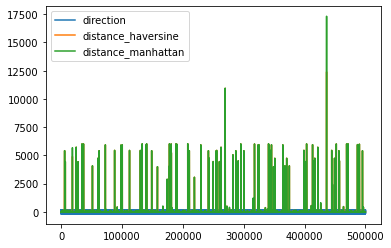

In [91]:
df_train[['direction', 'distance_haversine', 'distance_manhattan']].plot()

In [93]:
df_train.head()

key  fare_amount     pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5 2009-06-15 17:26:21   
1    2010-01-05 16:52:16.0000002         16.9 2010-01-05 16:52:16   
2   2011-08-18 00:35:00.00000049          5.7 2011-08-18 00:35:00   
3    2012-04-21 04:30:42.0000001          7.7 2012-04-21 04:30:42   
4  2010-03-09 07:51:00.000000135          5.3 2010-03-09 07:51:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count        date      time  ...  week_hour  dayofyear  month  \
0                1  2009-06-15  17:26:21  ...         17        166      6   
1                1  2010-01-05  16:52:16  ...         40          5      1   
2                2  2011-08-18  00:35:00  ...         72        230      8   
3                1  2012-04-21  04:30:42  ...        124        112      4   
4                1  2010-03-09  07:51:00  ...         31         68      3   

   pickup_holiday  pickup_near_holiday   direction  distance_haversine  \
0               0                    0  167.240469            1.030764   
1               0                    0   21.498365            8.450134   
2               0                    0 -148.966789            1.389525   
3               0                    0   -7.672164            2.799270   
4               0                    0   28.802783            1.999157   

   distance_manhattan  center_latitude  center_longitude  
0            1.232937        40.716798        -73.842961  
1           10.961646        40.746654        -73.997658  
2            1.906909        40.755916        -73.986990  
3            3.148058        40.745617        -73.989349  
4            2.715180        40.775885        -73.962375  

[5 rows x 25 columns]

# UNI-VARIATE ANALYSIS

In [94]:
# Finding number of trips with 0 travelled distance which come out to be 5894.

df_train[(df_train['distance_haversine']==0)].count()

key                    4787
fare_amount            4787
pickup_datetime        4787
pickup_longitude       4787
pickup_latitude        4787
dropoff_longitude      4787
dropoff_latitude       4787
passenger_count        4787
date                   4787
time                   4787
weekday                4787
weekofyear             4787
hour                   4787
minute                 4787
dt                     4787
week_hour              4787
dayofyear              4787
month                  4787
pickup_holiday         4787
pickup_near_holiday    4787
direction              4787
distance_haversine     4787
distance_manhattan     4787
center_latitude        4787
center_longitude       4787
dtype: int64

C:\Users\Rohan Kapur\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Rohan Kapur\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Rohan Kapur\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passin

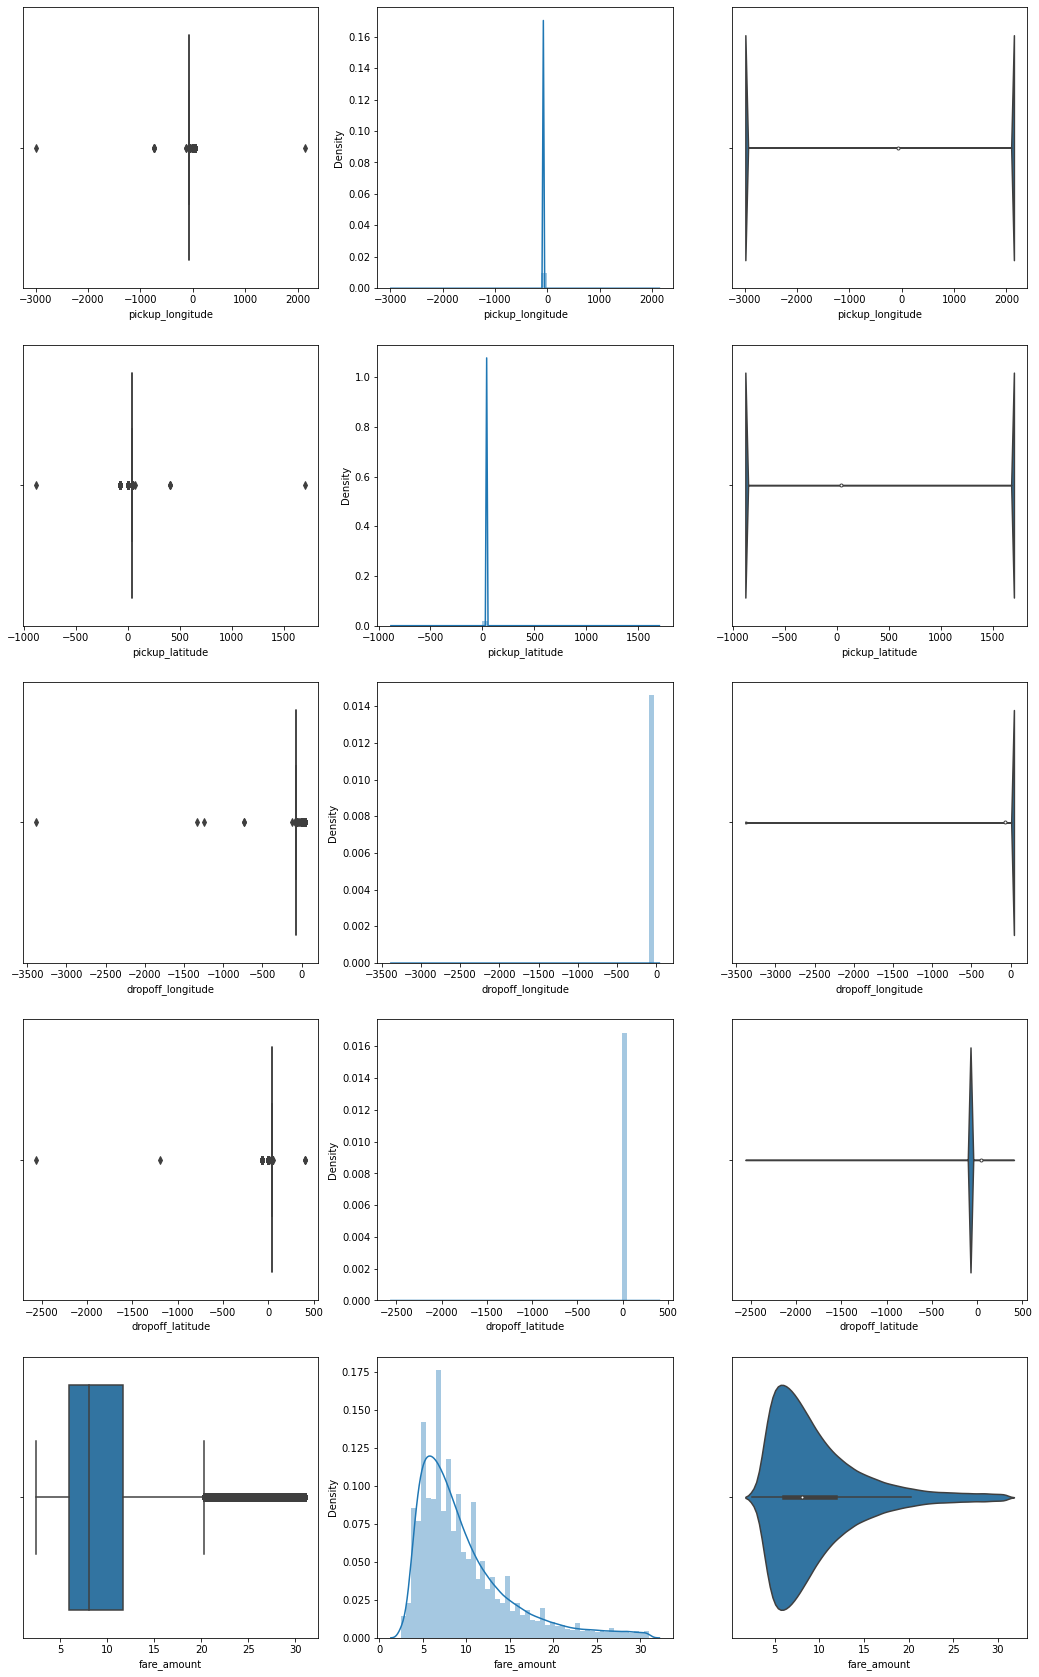

In [97]:


nums = pd.DataFrame(df_train[['pickup_longitude',	'pickup_latitude',	'dropoff_longitude',	'dropoff_latitude',	'fare_amount',	]])

f, axes = plt.subplots(5, 3, figsize=(18, 30))


count = 0
for var in nums:
    sns.boxplot(nums[var], orient = "h", ax = axes[count,0])
    sns.distplot(nums[var], ax = axes[count,1])
    sns.violinplot(nums[var], ax = axes[count,2])
    count += 1

C:\Users\Rohan Kapur\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


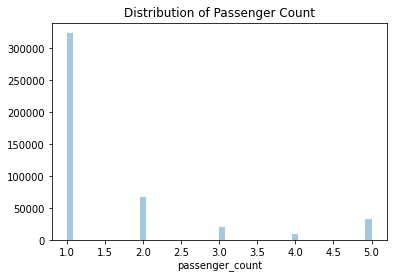

In [99]:
# Passenger Count Distribution

sns.distplot(df_train['passenger_count'],kde=False)
plt.title('Distribution of Passenger Count')
plt.show()

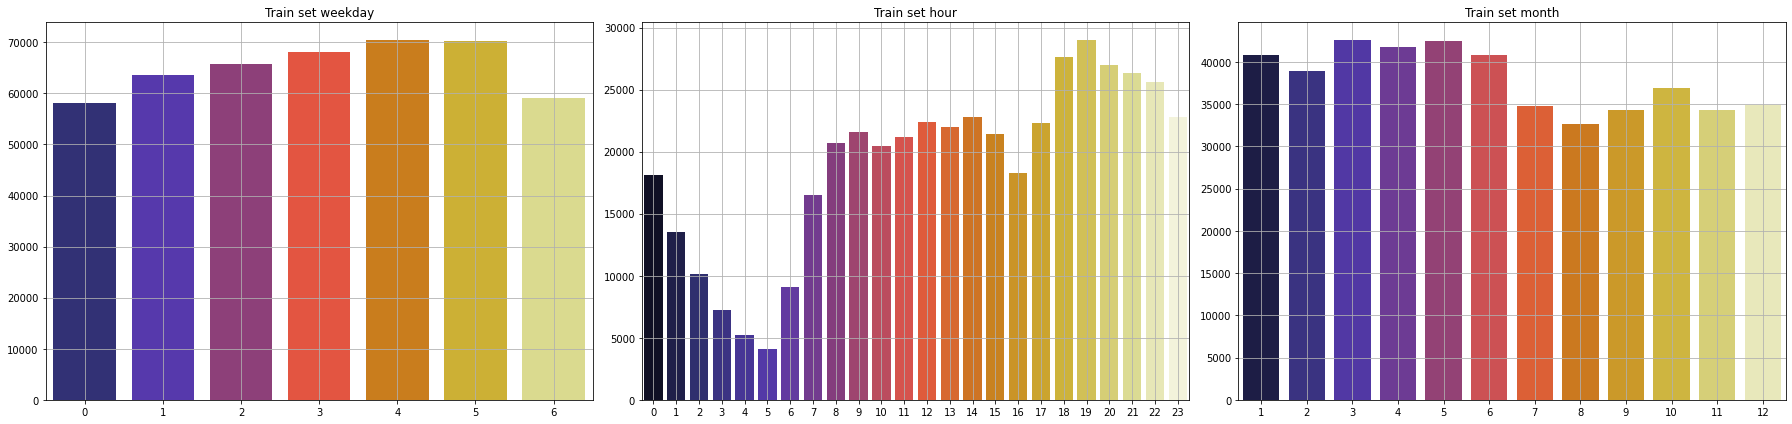

In [101]:
# Count of occurences of each pickup day, pickup hour and pickup month

fig, sub = plt.subplots(1,3,figsize=(25,6))
counter = 0

for feat, subplot in zip(["weekday","hour", "month"], sub.flatten()):
    
    if counter < 3:
        sns.barplot(x=df_train[feat].value_counts().index, y = df_train[feat].value_counts().values, ax= subplot, palette="CMRmap")
        subplot.grid()
        subplot.set_title("Train set {}".format(feat))
    
    counter+=1
    
fig.tight_layout()

[Text(0.5, 0, 'The cost of the trip in dollars'), Text(0, 0.5, 'Trip Count')]

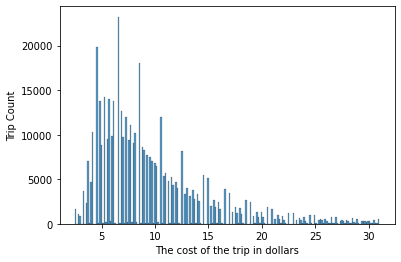

In [103]:
# Histogram to visualise counts for each Fare Amount 

graph = sns.histplot(df_train["fare_amount"], bins = 200)
graph.set(xlabel='The cost of the trip in dollars', ylabel='Trip Count')

[Text(0.5, 0, 'The cost of the trip in dollars (Normalised)'),
 Text(0, 0.5, 'Trip Count')]

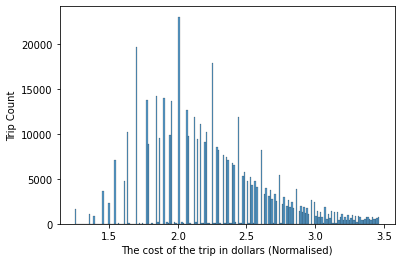

In [104]:
# Histogram to visualise counts for each Fare Amount, with logarithmic normalisation/scaling

df_train['fare_norm'] = np.log(df_train['fare_amount'].values + 1)
graph = sns.histplot(df_train["fare_norm"], bins = 200)
graph.set(xlabel='The cost of the trip in dollars (Normalised)', ylabel='Trip Count')

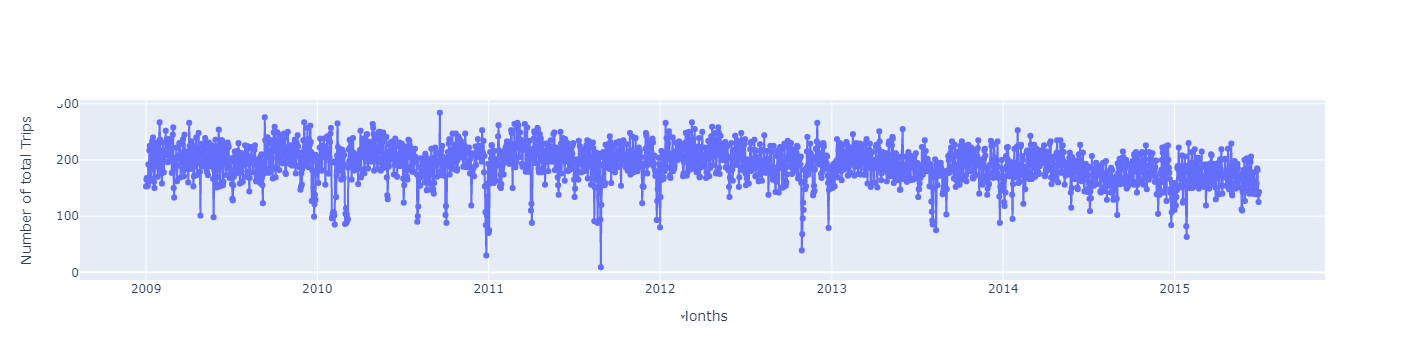

In [107]:
# Visualise Trips Count by Pick Up date

fig = go.Figure()
date_count = pd.DataFrame(df_train.groupby('date').count()[['key']])
date_count.index.name = 'Dates'
date_count.reset_index(inplace=True)


fig.add_trace(go.Scatter(x=date_count['Dates'], y=date_count['key'],
                    mode='lines+markers',
                    name='lines+markers'))

fig.update_xaxes(title_text="Months")
fig.update_yaxes(title_text="Number of total Trips")

# BI-VARIATE ANALYSIS

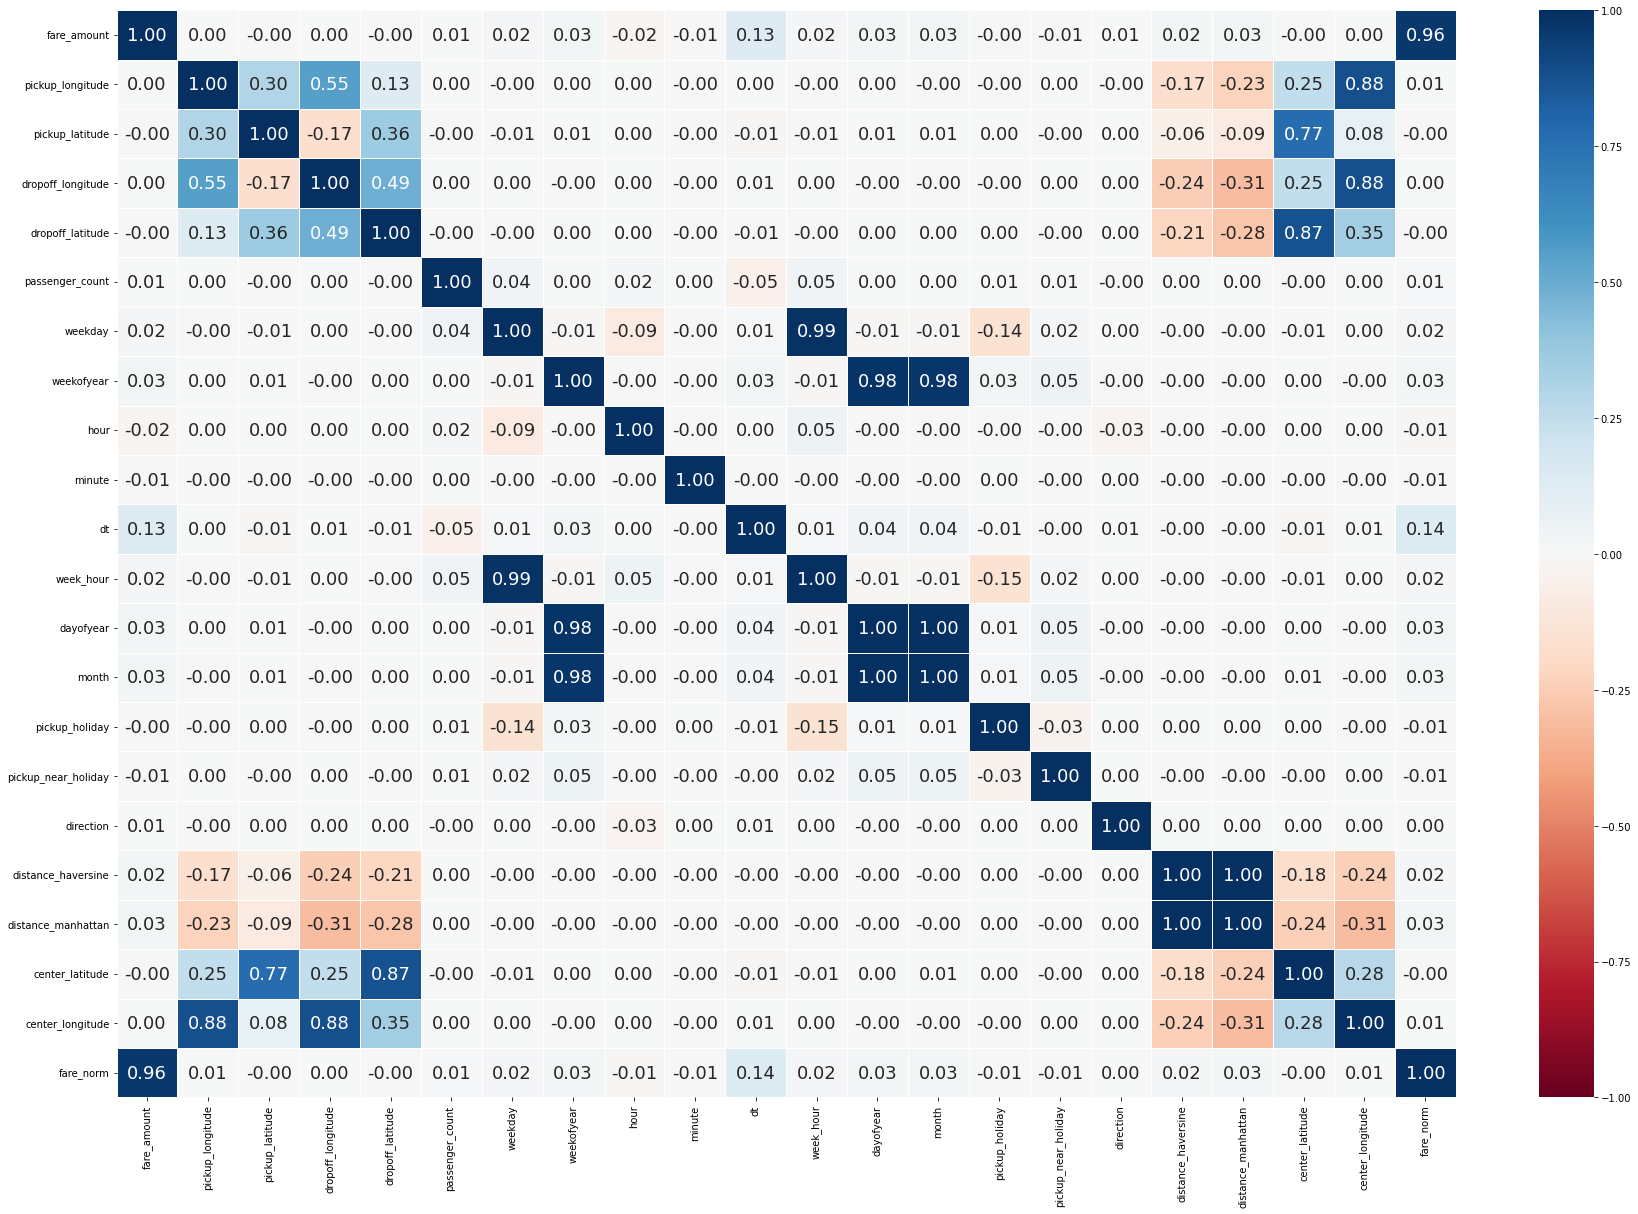

In [108]:
# Heap Map to visualise Feature Correlation

f, axes = plt.subplots(1, 1, figsize=(20, 20))
sns.heatmap(df_train.corr(), vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 18}, cmap = "RdBu")
f.set_figwidth(30)

C:\Users\Rohan Kapur\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='passenger_count', ylabel='Cost in dollars'>

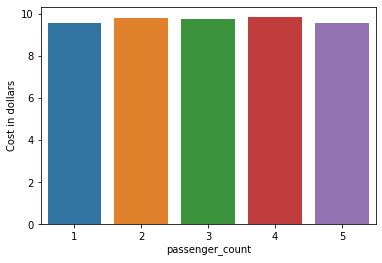

In [110]:
# Passenger Count VS Fare Amount in dollars

passenger_count_df = df_train.groupby('passenger_count')['fare_amount'].mean()
plt.ylabel('Cost in dollars')
sns.barplot(passenger_count_df.index, passenger_count_df.values)

C:\Users\Rohan Kapur\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='passenger_count', ylabel='Trip Distance in KM'>

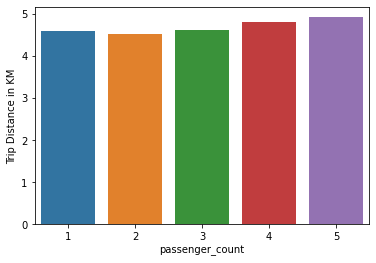

In [111]:
# Passenger Count VS Trip Distance

passenger_count_distance_df = df_train.groupby('passenger_count')['distance_manhattan'].mean()
plt.ylabel('Trip Distance in KM')
sns.barplot(passenger_count_distance_df.index, passenger_count_distance_df.values)

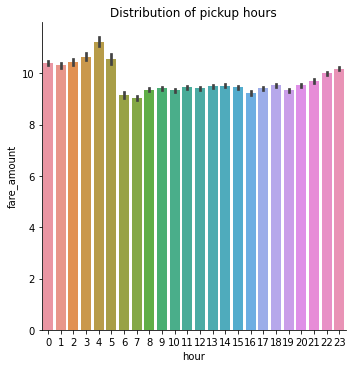

In [113]:

ax=sns.catplot(x="hour", y="fare_amount",kind="bar",data=df_train)
plt.title('Distribution of pickup hours')
plt.show()

Text(0.5, 1.0, 'The Average Fare Amount per PickUp Day of the Week')

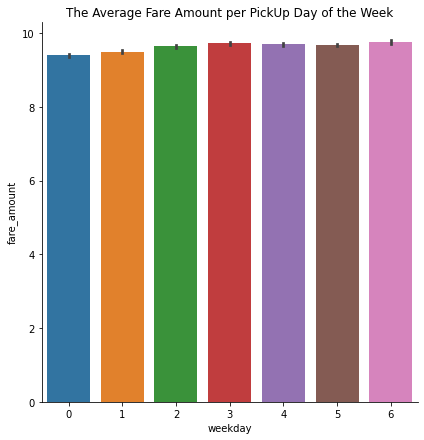

In [114]:
# Relationship b/w Fare Amount and Day of Week

sns.catplot(x="weekday",y="fare_amount",kind="bar",data=df_train,height=6,aspect=1)
plt.title('The Average Fare Amount per PickUp Day of the Week')

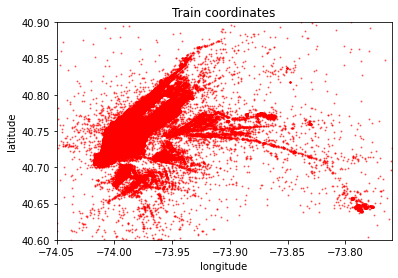

In [115]:
# Visualise PickUp Locations Density by plotting corresponding Longitudes/Latitudes

fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
ax.scatter(df_train['pickup_longitude'].values[:625134], df_train['pickup_latitude'].values[:625134],
              color='red', s=1, label='train', alpha=0.5)

ax.title.set_text('Train coordinates')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
plt.xlim(-74.05, -73.76)
plt.ylim(40.60, 40.90)
plt.show()

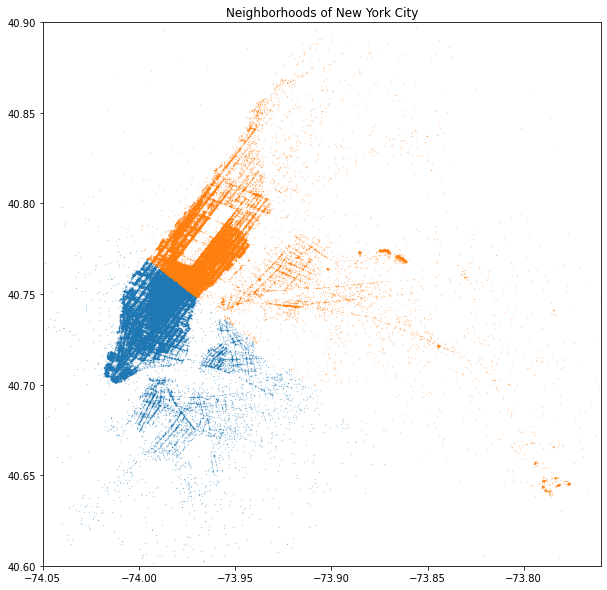

In [116]:
# Visualise main Neighbourhoods of New York City 

from sklearn.cluster import KMeans

coordinates_df = pd.DataFrame()
coordinates_df['all_longitude'] = list(df_train.pickup_longitude) + list(df_train.dropoff_longitude)
coordinates_df['all_latitude'] = list(df_train.pickup_latitude) + list(df_train.dropoff_latitude)

kmeans = KMeans(n_clusters=20, random_state=2, n_init = 10).fit(coordinates_df)
coordinates_df['kmeans_label'] = kmeans.labels_

coordinates_df = coordinates_df.sample(200000)
plt.figure(figsize = (10,10))
for label in coordinates_df.kmeans_label.unique():
    plt.plot(coordinates_df.all_longitude[coordinates_df.kmeans_label == label],coordinates_df.all_latitude[coordinates_df.kmeans_label == label],'.', alpha = 0.5, markersize = 0.5)

plt.title('Neighborhoods of New York City')
plt.xlim(-74.05, -73.76)
plt.ylim(40.60, 40.90)
plt.show()

In [117]:
# Use folium to visualize pickup and dropoff points in New York

import folium
f = folium.Figure(width=1500, height=500)
mapa = folium.Map(location = (40.7679, -73.9822), zoom_start=11).add_to(f)

for index, row in df_train.sample(1000).iterrows():
    folium.Marker([row["pickup_latitude"], row["pickup_longitude"]], icon=folium.Icon(color="blue")).add_to(mapa)
    folium.Marker([row["dropoff_latitude"], row["dropoff_longitude"]], icon=folium.Icon(color="red")).add_to(mapa)


display(mapa)

## Additional Dataset: Weather Dataset

In [118]:
# Read in the weather dataset
weather_data = pd.read_csv('https://firebasestorage.googleapis.com/v0/b/pizzarush-40b2f.appspot.com/o/weather_data_nyc_centralpark_2016(1).csv?alt=media&token=a6fb7ce8-b4bc-4bc5-ac07-132a078bea85') # Replace with firebase link when available
weather_data.head()

date  maximum temperature  minimum temperature  average temperature  \
0  1-1-2016                   42                   34                 38.0   
1  2-1-2016                   40                   32                 36.0   
2  3-1-2016                   45                   35                 40.0   
3  4-1-2016                   36                   14                 25.0   
4  5-1-2016                   29                   11                 20.0   

  precipitation snow fall snow depth  
0          0.00       0.0          0  
1          0.00       0.0          0  
2          0.00       0.0          0  
3          0.00       0.0          0  
4          0.00       0.0          0

In [119]:
weather_data.describe()

maximum temperature  minimum temperature  average temperature
count           366.000000           366.000000           366.000000
mean             64.625683            49.806011            57.215847
std              18.041787            16.570747            17.124760
min              15.000000            -1.000000             7.000000
25%              50.000000            37.250000            44.000000
50%              64.500000            48.000000            55.750000
75%              81.000000            65.000000            73.500000
max              96.000000            81.000000            88.500000

In [120]:
weather_data.dtypes

date                    object
maximum temperature      int64
minimum temperature      int64
average temperature    float64
precipitation           object
snow fall               object
snow depth              object
dtype: object

WEATHER DATASET: FORMAT DATA

In [121]:
# Convert the data values to float which could be plotted and convert the string values containing 'T' for 'Trace' to 0.00

import matplotlib.pyplot as plt
%matplotlib inline

weather_data.loc[weather_data['precipitation']== 'T', 'precipitation'] = '0.00'
weather_data['precipitation'] = (weather_data['precipitation']).astype(float)

weather_data.loc[weather_data['snow fall']== 'T', 'snow fall'] = '0.00'
weather_data['snow fall'] = (weather_data['snow fall']).astype(float)

weather_data.loc[weather_data['snow depth']== 'T', 'snow depth'] = '0.00'
weather_data['snow depth'] = (weather_data['snow depth']).astype(float)

In [122]:
weather_data['date'] = pd.to_datetime(weather_data.date)
weather_data['weather_dayofyear']= weather_data.date.dt.dayofyear

C:\Users\Rohan Kapur\AppData\Local\Temp\ipykernel_20652\2873123135.py:1: UserWarning:

Parsing '13-10-2016' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

C:\Users\Rohan Kapur\AppData\Local\Temp\ipykernel_20652\2873123135.py:1: UserWarning:

Parsing '14-10-2016' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

C:\Users\Rohan Kapur\AppData\Local\Temp\ipykernel_20652\2873123135.py:1: UserWarning:

Parsing '15-10-2016' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

C:\Users\Rohan Kapur\AppData\Local\Temp\ipykernel_20652\2873123135.py:1: UserWarning:

Parsing '16-10-2016' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

C:\Users\Rohan Kapur\AppData\Local\Temp\ipykernel_20652\2873123135.py:1: UserWarning:

Parsing '17-10-2016' in DD/MM/YYYY format. Provide format or specify infer_dateti

WEATHER DATASET: UNIVARIATE ANALYSIS

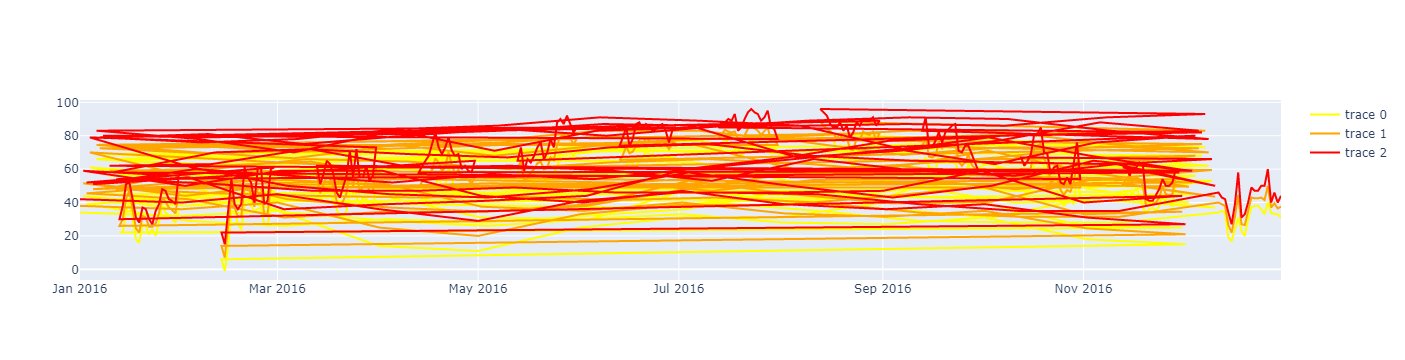

In [123]:
# Plot min (yellow), avg (orange), and max (red) temperatures over time

import plotly.express as px
import plotly.graph_objects as go

# plotly.graph_objects
colors = ['yellow', 'orange', 'red']
fig = go.Figure()
fig.add_traces(go.Scatter(x=weather_data['date'], y = weather_data['minimum temperature'], mode = 'lines', line=dict(color=colors[0])))
fig.add_traces(go.Scatter(x=weather_data['date'], y = weather_data['average temperature'], mode = 'lines', line=dict(color=colors[1])))
fig.add_traces(go.Scatter(x=weather_data['date'], y = weather_data['maximum temperature'], mode = 'lines', line=dict(color=colors[2])))
fig.show()

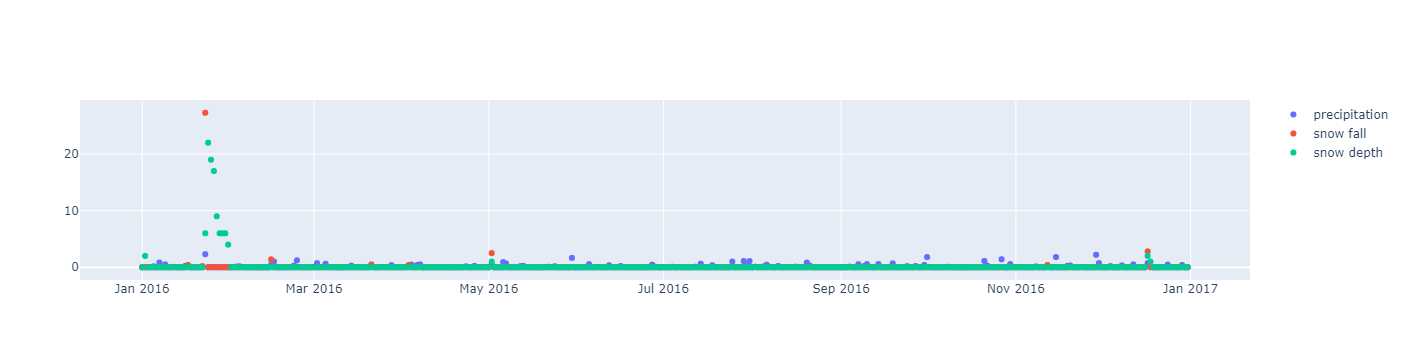

In [124]:
# Plot precipitation, snow fall, and snow depth 

import plotly as py
import plotly.graph_objs as go
import plotly

x_data = weather_data['date'].values
y0_data = weather_data['precipitation']
y1_data = weather_data['snow fall']
y2_data = weather_data['snow depth']

data0 = go.Scatter(
    x = x_data,
    y = y0_data,
    mode = 'markers',
    name = 'precipitation'
)
data1 = go.Scatter(
    x = x_data,
    y = y1_data,
    mode = 'markers',
    name = 'snow fall'
)
data2 = go.Scatter(
    x = x_data,
    y = y2_data,
    mode = 'markers',
    name = 'snow depth'
)

data = [data0, data1, data2]
plotly.offline.iplot(data, filename='scatter-mode')

In [126]:
df_train['date'] = df_train['pickup_datetime'].dt.date
df_train['date'] = pd.to_datetime(df_train['date'])
weather = weather_data[['date','minimum temperature', 'precipitation', 'snow fall', 'snow depth']]
df_train = df_train.merge(weather, how='left', left_on='date', right_on='date')

In [127]:
df_test['date'] = df_test['pickup_datetime'].dt.date
df_test['date'] = pd.to_datetime(df_test['date'])
df_test = df_test.merge(weather, how='left', left_on='date', right_on='date')

In [19]:
df_train.drop('pickup_datetime', axis = 1, inplace = True)
df_train.drop('key', axis = 1, inplace = True)
df_test.drop('pickup_datetime', axis = 1, inplace = True)
df_test.drop('key', axis = 1, inplace = True)

In [21]:
df_train = optimize(df_train)
df_test = optimize(df_test)

# FEATURE SELECTION

In [22]:
# PCA - Reducing the dimentionality of the features

from sklearn.decomposition import PCA

coords = np.vstack((df_train[['pickup_latitude', 'pickup_longitude']].values,
                    df_train[['dropoff_latitude', 'dropoff_longitude']].values,
                    df_test[['pickup_latitude', 'pickup_longitude']].values,
                    df_test[['dropoff_latitude', 'dropoff_longitude']].values))

pca = PCA().fit(coords) # fit the PCA model according to the coordinate values

In [23]:
df_train['pickup_pca0'] = pca.transform(df_train[['pickup_latitude', 'pickup_longitude']])[:, 0] # Derive the PCA feature for Pickup Latitude in Train Dataset
df_train['pickup_pca1'] = pca.transform(df_train[['pickup_latitude', 'pickup_longitude']])[:, 1] # Derive the PCA feature for Pickup Longitude in Train Dataset
df_train['dropoff_pca0'] = pca.transform(df_train[['dropoff_latitude', 'dropoff_longitude']])[:, 0] # Derive the PCA feature for Dropoff Latitude in Train Dataset
df_train['dropoff_pca1'] = pca.transform(df_train[['dropoff_latitude', 'dropoff_longitude']])[:, 1] # Derive the PCA feature for Dropoff Longitude in Train Dataset
df_test['pickup_pca0'] = pca.transform(df_test[['pickup_latitude', 'pickup_longitude']])[:, 0] # Derive the PCA feature for Pickup Latitude in Test Dataset
df_test['pickup_pca1'] = pca.transform(df_test[['pickup_latitude', 'pickup_longitude']])[:, 1] # Derive the PCA feature for Pickup Longitude in Test Dataset
df_test['dropoff_pca0'] = pca.transform(df_test[['dropoff_latitude', 'dropoff_longitude']])[:, 0] # Derive the PCA feature for Dropoff Latitude in Test Dataset
df_test['dropoff_pca1'] = pca.transform(df_test[['dropoff_latitude', 'dropoff_longitude']])[:, 1] # Derive the PCA feature for Dropoff Longitutde in Test Dataset

df_train.loc[:, 'pca_manhattan'] = np.abs(df_train['dropoff_pca1'] - df_train['pickup_pca1']) + np.abs(df_train['dropoff_pca0'] - df_train['pickup_pca0']) # Calculate the Manhattan Distance with PCA Coordinates for Train Dataset
df_test.loc[:, 'pca_manhattan'] = np.abs(df_test['dropoff_pca1'] - df_test['pickup_pca1']) + np.abs(df_test['dropoff_pca0'] - df_test['pickup_pca0']) #Calculate the Manhattan Distance with PCA Coordinated for Test Dataset

C:\Users\Rohan Kapur\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
C:\Users\Rohan Kapur\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
C:\Users\Rohan Kapur\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
C:\Users\Rohan Kapur\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
C:\Users\Rohan Kapur\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
C:\Users\Rohan Kapur\AppData\Local\Progr

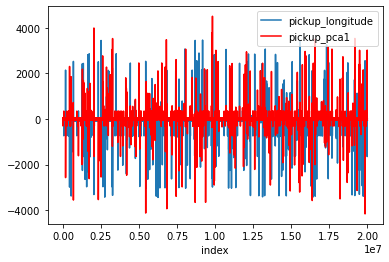

In [24]:
# Visualising a PCA Feature - Pickup Longitude (pickup_pca1) from Train Dataset

ax = plt.gca()

df_train.reset_index().plot(kind='line', x='index', y='pickup_longitude',ax=ax)
df_train.reset_index().plot(kind='line', x='index', y='pickup_pca1', color='green', ax=ax)

plt.show()

# CLUSTERING

In [27]:
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

In [28]:
df_train.loc[:, 'pickup_cluster'] = kmeans.predict(df_train[['pickup_latitude', 'pickup_longitude']])
df_train.loc[:, 'dropoff_cluster'] = kmeans.predict(df_train[['dropoff_latitude', 'dropoff_longitude']])
df_test.loc[:, 'pickup_cluster'] = kmeans.predict(df_test[['pickup_latitude', 'pickup_longitude']])
df_test.loc[:, 'dropoff_cluster'] = kmeans.predict(df_test[['dropoff_latitude', 'dropoff_longitude']])

C:\Users\Rohan Kapur\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MiniBatchKMeans was fitted without feature names
  warnings.warn(
C:\Users\Rohan Kapur\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MiniBatchKMeans was fitted without feature names
  warnings.warn(
C:\Users\Rohan Kapur\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MiniBatchKMeans was fitted without feature names
  warnings.warn(
C:\Users\Rohan Kapur\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MiniBatchKMeans was fitted without feature names
  warnings.warn(


# MODEL TRAINING

In [39]:
# Listing out the features that should be used for training the XGB Model.

feature_names = list(df_train.columns)
features_not_used = ['id', 'fare_amount_normalised', 'fare_amount', 'dropoff_datetime','dropoff_date','dropoff_hour',
                           'dropoff_month','dropoff_time','dropoff_weekday', 'date', 'datetime', 'date','time','month', 'fare_norm']
feature_names = [f for f in df_train.columns if f not in features_not_used]
df_train[feature_names].count()

pickup_longitude       18174893
pickup_latitude        18174893
dropoff_longitude      18174893
dropoff_latitude       18174893
passenger_count        18174893
weekday                18174893
weekofyear             18174893
hour                   18174893
minute                 18174893
dt                     18174893
week_hour              18174893
dayofyear              18174893
pickup_holiday         18174893
pickup_near_holiday    18174893
direction              18174893
distance_haversine     18174893
distance_manhattan     18174893
center_latitude        18174893
center_longitude       18174893
pickup_pca0            18174893
pickup_pca1            18174893
dropoff_pca0           18174893
dropoff_pca1           18174893
pca_manhattan          18174893
pickup_cluster         18174893
dropoff_cluster        18174893
dtype: int64

In [30]:
# Performing k-fold splits

X = df_train[feature_names].values
y = np.log(df_train['fare_amount'].values + 1)  
kf = KFold(n_splits=10)
kf.get_n_splits(X)

print(kf)  

KFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

KFold(n_splits=10, random_state=None, shuffle=False)
TRAIN: [ 1819428  1819429  1819430 ... 18194272 18194273 18194274] TEST: [      0       1       2 ... 1819425 1819426 1819427]
TRAIN: [       0        1        2 ... 18194272 18194273 18194274] TEST: [1819428 1819429 1819430 ... 3638853 3638854 3638855]
TRAIN: [       0        1        2 ... 18194272 18194273 18194274] TEST: [3638856 3638857 3638858 ... 5458281 5458282 5458283]
TRAIN: [       0        1        2 ... 18194272 18194273 18194274] TEST: [5458284 5458285 5458286 ... 7277709 7277710 7277711]
TRAIN: [       0        1        2 ... 18194272 18194273 18194274] TEST: [7277712 7277713 7277714 ... 9097137 9097138 9097139]
TRAIN: [       0        1        2 ... 18194272 18194273 18194274] TEST: [ 9097140  9097141  9097142 ... 10916564 10916565 10916566]
TRAIN: [       0        1        2 ... 18194272 18194273 18194274] TEST: [10916567 10916568 10916569 ... 12735991 12735992 12735993]
TRAIN: [       0        1        2 ... 1819427

In [31]:
X, y = df_train[feature_names], df_train['fare_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [32]:
#del df
import gc 
gc.collect()


734

In [33]:
# Setting the XGB Parameters
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)
dtest = xgb.DMatrix(df_test[feature_names].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

params = {'learning_rate': 0.05,
    'max_depth': 11,
    'objective': 'reg:squarederror',
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 1,
    'gamma': 1,
    'silent': True,
    'verbose_eval': True,
    'booster' : 'gbtree',
    'eval_metric': 'rmse',
    'tree_method':'gpu_hist',
    'n_gpus': 1}

In [34]:
%%time
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)
dtest = xgb.DMatrix(df_test[feature_names])
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

model = xgb.train(params, dtrain, num_boost_round=7000, evals = watchlist, early_stopping_rounds= 100, verbose_eval=100)

[14:10:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_gpus", "silent", "verbose_eval" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:10.01988	valid-rmse:10.01728
[100]	train-rmse:1.98294	valid-rmse:2.00284
[200]	train-rmse:1.91553	valid-rmse:1.95253
[300]	train-rmse:1.87785	valid-rmse:1.93028
[400]	train-rmse:1.85255	valid-rmse:1.91880
[500]	train-rmse:1.83364	valid-rmse:1.91206
[600]	train-rmse:1.81642	valid-rmse:1.90698
[700]	train-rmse:1.80139	valid-rmse:1.90290
[800]	train-rmse:1.78645	valid-rmse:1.89919
[900]	train-rmse:1.77389	valid-rmse:1.89666
[1000]	train-rmse:1.76213	valid-rmse:1.89473
[1100]	train-rmse:1.75072	valid-rmse:1.89301
[1200]	train-rmse:1.73990	val

# MODEL PREDICTION 

In [ ]:
# Predicting the model on test data

In [36]:
y_test = model.predict(dtest)
y_pred = model.predict(dvalid)
submission = pd.DataFrame(
    {'key': key, 'fare_amount': y_test},
    columns = ['key', 'fare_amount'])
submission.to_csv('submission_finAL.csv', index = False)

Test and Predicted Data have the same shape!
Mean of valid preds: 9.607
mean of test preds: 10.211


C:\Users\Rohan Kapur\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Rohan Kapur\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


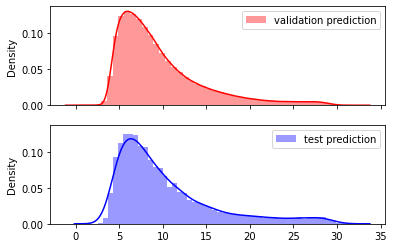

In [37]:
# Check the number of rows of test data to be matching with predicted data.
if df_test.shape[0] == y_test.shape[0]:
  print('Test and Predicted Data have the same shape!')  
else:
  print('Error! Test data not in right format')

# Plot validation and test prediction mean
print('Mean of valid preds: %.3f' % y_pred.mean())
print('mean of test preds: %.3f' % y_test.mean())
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
sns.distplot(y_pred, ax=ax[0], color='red', label='validation prediction')
sns.distplot(y_test, ax=ax[1], color='blue', label='test prediction')
ax[0].legend(loc=0)
ax[1].legend(loc=0)
plt.show()